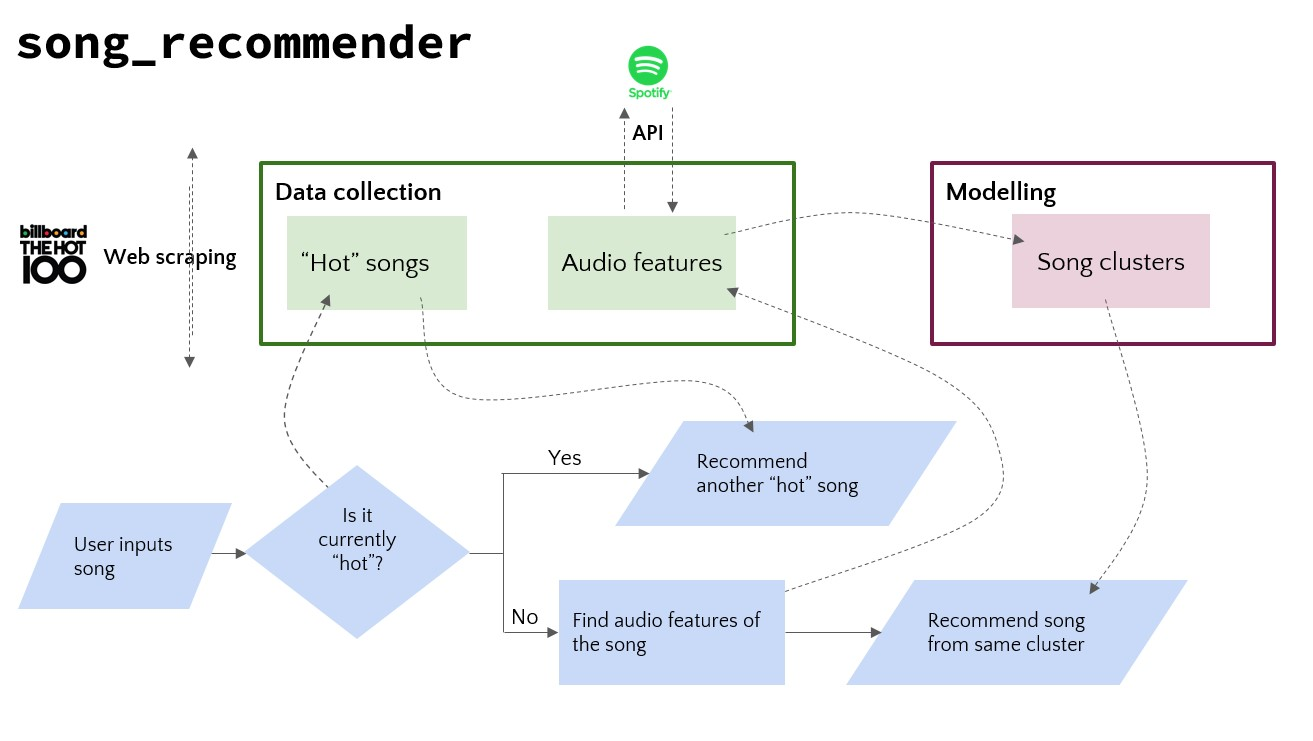

In [6]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from scipy.spatial import distance
    
def song_recommender():
    # Loading/Reading the CSV data
    billboard_df = pd.read_csv('data/billboard_data.csv')
    spotify_df = pd.read_csv('data/spotify_data.csv')
    
    # Receiving input from the user
    input_song = input('Please enter a song name: ')
    
    # Checking if the input song is in the billboard_df dataframe
    if input_song.lower() in billboard_df['name'].str.lower().values:        
        # Finding a random song from the billboard_df dataframe that is not the same as the input song
        input_song_row = billboard_df[billboard_df['name'].str.lower() == input_song.lower()]
        filtered_billboard_df = billboard_df.drop(input_song_row.index)
        random_recommendation = filtered_billboard_df.sample()
        
        # Printing the recommended song with its artist
        print(f"Recommended song: {random_recommendation.iloc[0]['name']} by {random_recommendation.iloc[0]['artist']}")
 

    else:
        # Setting up Spotipy
        client_credentials_manager = SpotifyClientCredentials(client_id="426e22a5ddc84900acb6d605bb0a2cdf", client_secret="a49cdbf32d6c46beb53c014afad4078f")
        sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

        # Getting the input song
        search_result = sp.search(q=input_song, type='track', limit=1)
        input_song_data = search_result['tracks']['items'][0]
        input_song_id = input_song_data['id']

        # Getting the input song features
        input_song_features = sp.audio_features(input_song_id)[0]
        input_song_data = {
            key: input_song_features[key]
            for key in [
                'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                'key', 'mode', 'time_signature'
            ]
        }
        input_song = list(input_song_data.values())

        # Determining the input song cluster
        kmeans = KMeans(n_clusters=6)
        features = spotify_df.drop(['id', 'name', 'artist', 'clusters'], axis=1)
        kmeans.fit(features)
        input_song_cluster = kmeans.predict([input_song])[0]

        # Getting songs in the same cluster
        same_cluster_songs = spotify_df[spotify_df['clusters'] == input_song_cluster]

        # Finding closest song
        closest_song = None
        min_distance = float('inf')
        for _, row in same_cluster_songs.iterrows():
            row_features = row[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                        'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                        'key', 'mode', 'time_signature']].values
            row_key_mode_ts = row[['key', 'mode', 'time_signature']].values
            input_key_mode_ts = [input_song_features['key'], input_song_features['mode'], input_song_features['time_signature']]
            row_features = np.append(row_features, row_key_mode_ts)
            input_features = np.append(input_song, input_key_mode_ts)

            dist = distance.euclidean(row_features, input_features)
            if dist < min_distance:
                min_distance = dist
                closest_song = row

        # Printing the recommended song with its artist
        print(f"Recommended song: {closest_song['name']} by {closest_song['artist']}")

In [7]:
song_recommender()

Please enter a song name: Last Night
Recommended song: I Deserve A Drink by Morgan Wallen


In [8]:
song_recommender()

Please enter a song name: I Deserve A Drink
Recommended song: Painting Pictures by Superstar Pride


In [9]:
song_recommender()

Please enter a song name: Jungle


C:\Users\allab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Recommended song: Drunk on Your Love by Brett Eldredge


In [12]:
song_recommender()

Please enter a song name: Seven Nation Army


C:\Users\allab\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Recommended song: Something In The Way by Nirvana
